# Interesting text-to-video generation

This is a nb which contains interesting text-to-video generation methods


For running the program successfuly, please install the packages in a new environment(recommended) or the existing environment. Please run the following commands in terminal:
1. clone the repository
   
        git clone https://github.com/lindapu-1/Image-to-gif.git
        cd Image-to-gif
   
3. create a new environment and install the dependencies
   
        conda create -n video python=3.10 
        conda activate video  
        pip install -r requirements.txt 


Then the environment is ready. for running the notebook, you may need to install the ipykernal additionally. 

**it is important to use the right kernal of the environment to run the following cells, on the upper right corner of the jupyter notebook.**

### [1]Text-to-image generation
> this is a program to generate an image from a text, by using **Stable Diffusion** from the model of [CompVis](https://github.com/CompVis).

In [ ]:
##########################################################################################
#You can edit the prompt here
prompt = "a photo of an astronaut riding a horse on mars"
##########################################################################################

from huggingface_hub import snapshot_download
print("Downloading Stable Diffusion Model")
snapshot_download(repo_id="CompVis/stable-diffusion-v1-4", local_dir="./models/StableDiffusion/CompVis/stable-diffusion-v1-4")
print("Downloaded Stable Diffusion Model")
from diffusers import StableDiffusionPipeline
import torch

model_path = "./models/StableDiffusion/CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

with torch.autocast("cuda"):
    image = pipe(prompt).images[0]

image

##########################################################################################
#This cell may run for a while due to the large size of the model, for 2-3 minutes
##########################################################################################


### [2]Text-to-video generation
> this is a program to generate motions for an image, by using **AnimateDiff** from the model of [AnimateDiff](https://github.com/guoyww/AnimateDiff).

In [ ]:
##########################################################################################
#You can edit the prompt here!!!
prompt=["b&w photo of 42 y.o man in black clothes, bald, face, half body, body, high detailed skin, skin pores, coastline, overcast weather, wind, waves, 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3"]
##########################################################################################


#negative prompt and other parameters are also editable
n_prompt=["semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime, text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"]
steps=25
seed = [8964153601421814582]
guidance_scale=8


#you may ignore the following
parameter= [
        {
            "dreambooth_path": "",
            "lora_model_path": "",
            "inference_config": "configs/inference/inference-v2.yaml",
            "motion_module": "models/Motion_Module/mm_sd_v15_v2.ckpt",
            "seed": seed,
            "steps": steps,
            "guidance_scale":  guidance_scale,
            "prompt": prompt,
            "n_prompt": n_prompt
        }
           ]

# setup configuration
config = {
    "pretrained_model_path": "CompVis/stable-diffusion-v1-4",
    "inference_config": "configs/inference/inference-v1.yaml",
    "config": parameter,
    "L": 16,
    "W": 512,
    "H": 512,
    "without_xformers": False
}


In [7]:
#I modified the main code from animatediff to fit my needs.
import argparse
from types import SimpleNamespace
import datetime
import inspect
import os
from omegaconf import OmegaConf

import torch
import torchvision.transforms as transforms
import imageio
import cv2

import diffusers
from diffusers import AutoencoderKL, DDIMScheduler

from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

from animatediff.models.unet import UNet3DConditionModel
from animatediff.models.sparse_controlnet import SparseControlNetModel
from animatediff.pipelines.pipeline_animation import AnimationPipeline
from animatediff.utils.util import save_videos_grid
from animatediff.utils.util import load_weights, auto_download
from diffusers.utils.import_utils import is_xformers_available

from einops import rearrange, repeat

import csv, pdb, glob, math
from pathlib import Path
from PIL import Image
from IPython.display import display, Image as IPImage
import numpy as np

# Create a Namespace object
args = SimpleNamespace(**config)

@torch.no_grad()
def main(args):
    *_, func_args = inspect.getargvalues(inspect.currentframe())
    func_args = dict(func_args)
    
    time_str = datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    savedir = f"samples/custom-config-{time_str}"
    os.makedirs(savedir)

    config = args.config  # Now this is directly a list of dictionaries
    samples = []

    # create validation pipeline
    tokenizer    = CLIPTokenizer.from_pretrained(args.pretrained_model_path, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(args.pretrained_model_path, subfolder="text_encoder").cuda()
    vae          = AutoencoderKL.from_pretrained(args.pretrained_model_path, subfolder="vae").cuda()

    sample_idx = 0
    for model_idx, model_config in enumerate(config):
        model_config["W"] = model_config.get("W", args.W)
        model_config["H"] = model_config.get("H", args.H)
        model_config["L"] = model_config.get("L", args.L)

        inference_config = OmegaConf.load(model_config.get("inference_config", args.inference_config))
        unet = UNet3DConditionModel.from_pretrained_2d(args.pretrained_model_path, subfolder="unet", unet_additional_kwargs=OmegaConf.to_container(inference_config.unet_additional_kwargs)).cuda()
        
        # load controlnet model
        controlnet = controlnet_images = None
        
        # set xformers
        if is_xformers_available() and (not args.without_xformers):
            unet.enable_xformers_memory_efficient_attention()
            if controlnet is not None: controlnet.enable_xformers_memory_efficient_attention()

        pipeline = AnimationPipeline(
            vae=vae, text_encoder=text_encoder, tokenizer=tokenizer, unet=unet,
            controlnet=controlnet,
            scheduler=DDIMScheduler(**OmegaConf.to_container(inference_config.noise_scheduler_kwargs)),
        ).to("cuda")

        pipeline = load_weights(
            pipeline,
            # motion module
            motion_module_path         = model_config.get("motion_module", ""),
            motion_module_lora_configs = model_config.get("motion_module_lora_configs", []),
            # domain adapter
            adapter_lora_path          = model_config.get("adapter_lora_path", ""),
            adapter_lora_scale         = model_config.get("adapter_lora_scale", 1.0),
            # image layers
            dreambooth_model_path      = model_config.get("dreambooth_path", ""),
            lora_model_path            = model_config.get("lora_model_path", ""),
            lora_alpha                 = model_config.get("lora_alpha", 0.8),
        ).to("cuda")

        prompts = model_config["prompt"]
        n_prompts = model_config["n_prompt"]
        
        random_seeds = model_config.get("seed", [-1])
        random_seeds = [random_seeds] if isinstance(random_seeds, int) else list(random_seeds)
        random_seeds = random_seeds * len(prompts) if len(random_seeds) == 1 else random_seeds
        
        config[model_idx]['random_seed'] = []
        for prompt_idx, (prompt, n_prompt, random_seed) in enumerate(zip(prompts, n_prompts, random_seeds)):
            
            # manually set random seed for reproduction
            if random_seed != -1: torch.manual_seed(random_seed)
            else: torch.seed()
            config[model_idx]['random_seed'].append(torch.initial_seed())
            
            print(f"current seed: {torch.initial_seed()}")
            print(f"sampling {prompt} ...")
            sample = pipeline(
                prompt,
                negative_prompt     = n_prompt,
                num_inference_steps = model_config["steps"],
                guidance_scale = model_config["guidance_scale"],
                width = model_config["W"],
                height = model_config["H"],
                video_length = model_config["L"],

                controlnet_images = controlnet_images,
                controlnet_image_index = model_config.get("controlnet_image_indexs", [0]),
            ).videos
            samples.append(sample)

            prompt = "-".join((prompt.replace("/", "").split(" ")[:10]))
            save_videos_grid(sample, f"{savedir}/sample/{sample_idx}-{prompt}.mp4")
            print(f"save to {savedir}/sample/{prompt}.mp4")
            
            sample_idx += 1

    samples = torch.concat(samples)
    final_gif_path = f"{savedir}/sample.gif"
    save_videos_grid(samples, final_gif_path, n_rows=4)

    print(f"Final GIF saved to: {final_gif_path}")
    display(IPImage(filename=final_gif_path))


/root/miniconda3/envs/animatediff/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


loaded 3D unet's pretrained weights from CompVis/stable-diffusion-v1-4 ...
### missing keys: 546; 
### unexpected keys: 0;
### Motion Module Parameters: 453.20928 M
load motion module from models/Motion_Module/mm_sd_v15_v2.ckpt
current seed: 8964153601421814582
sampling b&w photo of 42 y.o man in black clothes, bald, face, half body, body, high detailed skin, skin pores, coastline, overcast weather, wind, waves, 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3 ...


100%|██████████| 16/16 [00:00<00:00, 22.09it/s]


save to samples/custom-config-2024-09-16T13-59-00/sample/b&w-photo-of-42-y.o-man-in-black-clothes,-bald,.mp4
Final GIF saved to: samples/custom-config-2024-09-16T13-59-00/sample.gif


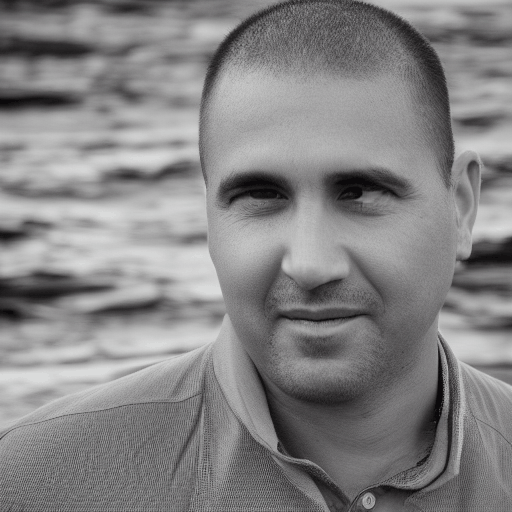

In [2]:
main(args)
##########################################################################################
#The output will be printed below. You can also find the output in the folder of "samples/custom-config-****T**-**-**"
#This cell may run for a longer time when first running, for ~3 minutes, as it is downloading the model.
##########################################################################################